<a href="https://colab.research.google.com/github/11doris/jazz-maestro/blob/colab_word_embeddings/embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall -y gensim

Found existing installation: gensim 3.6.0
Uninstalling gensim-3.6.0:
  Successfully uninstalled gensim-3.6.0


In [2]:
!pip install gensim

     |████████████████████████████████| 24.1 MB 2.7 kB/s 


In [3]:
!pip install hdbscan

     |████████████████████████████████| 6.4 MB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311933 sha256=93981dfcfc6ccb317df0861ff12df66580493a36711ecf3ea15b3382e2f775c4
  Stored in directory: /root/.cache/pip/wheels/73/5f/2f/9a259b84003b84847c259779206acecabb25ab56f1506ee72b
Successfully built hdbscan


In [4]:
import hdbscan

In [5]:
import gensim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pprint
import pandas as pd
import numpy as np
from collections import Counter
import plotly.express as px
from tqdm import tqdm 
from gensim.models.doc2vec import Doc2Vec

In [6]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [7]:
print(gensim.__version__)

4.1.2


# Initialization

## Download the Data

Full chords:

In [8]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1H8uRflGJGQecZlmy4jTK8aqKlyc-8C6y' -O input_seq.txt

--2021-11-09 08:31:57--  https://docs.google.com/uc?export=download&id=1H8uRflGJGQecZlmy4jTK8aqKlyc-8C6y
Resolving docs.google.com (docs.google.com)... 142.251.6.102, 142.251.6.101, 142.251.6.138, ...
Connecting to docs.google.com (docs.google.com)|142.251.6.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fp8of94jnva1q9qj9hokcfcbh4s8hsd3/1636446675000/14329102864480165501/*/1H8uRflGJGQecZlmy4jTK8aqKlyc-8C6y?e=download [following]
--2021-11-09 08:31:58--  https://doc-14-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/fp8of94jnva1q9qj9hokcfcbh4s8hsd3/1636446675000/14329102864480165501/*/1H8uRflGJGQecZlmy4jTK8aqKlyc-8C6y?e=download
Resolving doc-14-4c-docs.googleusercontent.com (doc-14-4c-docs.googleusercontent.com)... 209.85.200.132, 2607:f8b0:4001:c16::84
Connecting to doc-14-4c-docs.googleusercontent.com (doc-14-4c-docs.

Simplified chords:

In [9]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1fRbL2qj3eMHUsvnLbrn_ah6bOU58RaJ_' -O input_seq.txt

--2021-11-09 08:31:58--  https://docs.google.com/uc?export=download&id=1fRbL2qj3eMHUsvnLbrn_ah6bOU58RaJ_
Resolving docs.google.com (docs.google.com)... 173.194.194.138, 173.194.194.102, 173.194.194.139, ...
Connecting to docs.google.com (docs.google.com)|173.194.194.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/iigiar5mcl4rm62f25q3pu44v7g291j0/1636446675000/14329102864480165501/*/1fRbL2qj3eMHUsvnLbrn_ah6bOU58RaJ_?e=download [following]
--2021-11-09 08:31:58--  https://doc-10-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/iigiar5mcl4rm62f25q3pu44v7g291j0/1636446675000/14329102864480165501/*/1fRbL2qj3eMHUsvnLbrn_ah6bOU58RaJ_?e=download
Resolving doc-10-4c-docs.googleusercontent.com (doc-10-4c-docs.googleusercontent.com)... 209.85.200.132, 2607:f8b0:4001:c16::84
Connecting to doc-10-4c-docs.googleusercontent.com (doc-10-

Meta Data:

In [10]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Gy68KSn98UhfQm9YeRHjP6JsBzlN5z-S' -O input_meta.csv

--2021-11-09 08:31:59--  https://docs.google.com/uc?export=download&id=1Gy68KSn98UhfQm9YeRHjP6JsBzlN5z-S
Resolving docs.google.com (docs.google.com)... 142.251.6.101, 142.251.6.139, 142.251.6.138, ...
Connecting to docs.google.com (docs.google.com)|142.251.6.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ldqivljistfmthag5p11g5l7qpni157j/1636446675000/14329102864480165501/*/1Gy68KSn98UhfQm9YeRHjP6JsBzlN5z-S?e=download [following]
--2021-11-09 08:31:59--  https://doc-0k-4c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ldqivljistfmthag5p11g5l7qpni157j/1636446675000/14329102864480165501/*/1Gy68KSn98UhfQm9YeRHjP6JsBzlN5z-S?e=download
Resolving doc-0k-4c-docs.googleusercontent.com (doc-0k-4c-docs.googleusercontent.com)... 209.85.200.132, 2607:f8b0:4001:c16::84
Connecting to doc-0k-4c-docs.googleusercontent.com (doc-0k-4c-docs.

In [11]:
path_to_file = '/content/input_seq.txt'

with open(path_to_file) as f: 
  lines = f.read().splitlines()

In [12]:
data = [line.split(' ') for line in lines]

### Meta Data

In [13]:
meta = pd.read_csv('input_meta.csv', sep='\t')
meta.columns

Index(['id', 'file_name', 'title', 'composer', 'year', 'year_truncated',
       'tonality', 'tune_key', 'tune_mode', 'structure', 'num_bars',
       'time_signature', 'cycle_fifths_order', 'style', 'musicbrainz_id',
       'wikidata_id', 'wikidata_allmusic', 'wiki_link', 'wikidata_description',
       'lyricist'],
      dtype='object')

In [14]:
titles = meta.loc[:, ['id', 'title', 'tune_mode']].drop_duplicates()
titles.set_index('id', inplace=True)

In [15]:
assert len(data) == len(titles)

# Chord N-Grams



In [16]:
def ngrams(tokens, n=2, sep='-'):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

In [17]:
def list_to_ngrams(data, n=2, sep='-'):
  out = []
  for row in data:
    out.append(ngrams(row, n, sep))

  return out

In [18]:
data_ngrams = list_to_ngrams(data, 3)

In [19]:
def raw_chords_to_df(tunes):
  tunes_chords = [item for tune in tunes for item in tune]
  counts = Counter(tunes_chords)
  df = pd.DataFrame(counts.items(),
                    columns=['chord', 'count']).sort_values(by='count', ascending=False)

  return df

In [20]:
df_chords = raw_chords_to_df(data_ngrams)
df_chords.head(10)

,chord,count
14,Dm7-G7-CM7,1628
76,G7-C-C,1471
136,A7-Dm7-G7,1427
900,C-C-C,1056
184,Dm7-G7-C6,996
86,G7-G7-C,967
135,Em7-A7-Dm7,828
862,D7-G7-C,760
182,A7-D7-G7,742
71,Am7-Dm7-G7,650


In [21]:
df_chords = pd.DataFrame.from_dict(df_chords)
df_chords.sort_values(by=['count'], ascending=False, inplace=True)
df_chords_top = df_chords.query('count > 100')

fig = px.bar(df_chords_top, x='chord', y='count', log_y=True)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.show()

2021-11-09 08:32:01,788 : INFO : NumExpr defaulting to 2 threads.


# Word Embeddings

In [22]:
from gensim.models import word2vec


### Train model

In [23]:
train_data = data_ngrams
EMBED_SIZE = 100

In [24]:
# train model
model = gensim.models.Word2Vec(train_data, 
                               vector_size=EMBED_SIZE,
                               min_count=5,
                               sample=1, #0.1,
                               sg=1,
                               window=2,
                               negative=2,
                               epochs=50,
                               workers=4,
                               #alpha=0.025,
                               )

2021-11-09 08:32:04,244 : INFO : collecting all words and their counts
2021-11-09 08:32:04,247 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-11-09 08:32:04,292 : INFO : collected 13442 word types from a corpus of 89538 raw words and 2046 sentences
2021-11-09 08:32:04,294 : INFO : Creating a fresh vocabulary
2021-11-09 08:32:04,315 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 2440 unique words (18.152060705252193%% of original 13442, drops 11002)', 'datetime': '2021-11-09T08:32:04.315804', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'prepare_vocab'}
2021-11-09 08:32:04,317 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 71559 word corpus (79.92025732091402%% of original 89538, drops 17979)', 'datetime': '2021-11-09T08:32:04.317941', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021,

In [25]:
# summarize vocabulary
vocab = model.wv.index_to_key
print(vocab[:10])

['Dm7-G7-CM7', 'G7-C-C', 'A7-Dm7-G7', 'C-C-C', 'Dm7-G7-C6', 'G7-G7-C', 'Em7-A7-Dm7', 'D7-G7-C', 'A7-D7-G7', 'Am7-Dm7-G7']


In [26]:
weights = model.syn1neg

In [27]:
print(weights.shape)
vec_df = pd.DataFrame(weights, index=vocab)
vec_df.head()

(2440, 100)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
Dm7-G7-CM7,0.583019,-0.679470,-0.044555,0.054646,-0.203932,0.553410,-0.170871,-0.721280,0.576643,0.007402,0.371885,0.811167,0.035588,0.036900,-0.243137,0.488034,-0.149378,0.665668,0.094160,0.456708,-0.545094,-0.113124,-0.168240,0.191721,0.342400,0.032990,0.549062,0.435237,0.295265,0.053338,-0.510728,0.097635,0.223316,-0.067000,-0.497635,-0.065460,-0.242847,0.453209,0.213653,0.435741,...,-0.351597,-0.023348,0.327437,-0.322096,0.184307,-0.507467,0.120458,-0.422412,0.164381,-0.508652,0.343707,-0.758456,-0.833893,0.539653,-0.604762,-0.432189,-0.324526,0.226212,0.225162,0.127584,0.305305,-0.097245,0.262551,-0.597324,-0.403390,0.012167,0.203148,-0.316223,-0.507528,-0.469831,-0.472991,0.011547,-0.483353,0.013928,-0.740405,-0.349131,-0.282313,0.753762,-0.190140,-0.209147
G7-C-C,0.233614,-0.305298,-0.172158,0.047194,-0.009420,0.516718,0.256640,-1.372669,0.079029,-0.140823,0.461348,0.196015,0.182100,-0.569495,-0.446299,0.016539,0.328998,0.451659,-0.331358,0.484522,-0.236813,-0.277401,-0.328459,-0.162189,-0.986321,0.040057,-0.183884,0.154320,1.030890,0.229730,-0.696946,-0.288779,0.401299,-0.117931,-0.527568,-0.388917,0.332593,0.808377,-0.164584,1.773052,...,-0.354448,-0.932253,0.668336,-0.238100,0.008891,-0.624922,0.271275,0.581866,0.103745,-0.698251,-0.072787,-0.968531,-0.275666,0.719988,-0.767196,-0.507550,-0.188497,0.283721,0.231391,-0.068054,-0.153462,0.487084,-0.204465,-0.159325,0.133841,0.064110,0.178345,-0.250341,-0.189670,-0.224803,-0.016893,-0.200793,-0.821687,0.281318,-0.983194,-0.551521,-0.176372,0.638501,0.200132,-0.656150
A7-Dm7-G7,0.434635,-0.545241,-0.268212,0.092753,-0.112926,0.480670,-0.091510,-0.744654,0.304429,-0.042335,0.336853,0.674853,0.155739,0.019735,-0.203551,0.340580,-0.170222,0.763668,-0.017982,0.072162,-0.318785,-0.099432,-0.321661,0.024099,-0.001959,0.063005,0.530724,0.331416,0.294941,0.051030,-0.254789,0.013707,0.387752,0.170346,-0.463170,-0.070548,-0.049128,0.731905,0.185864,0.288458,...,-0.252619,-0.052886,0.443179,-0.386222,-0.010076,-0.221779,0.330500,-0.202119,0.105735,-0.425749,0.380964,-0.872411,-0.791685,0.518415,-0.422728,-0.179542,-0.324362,0.248117,0.414406,0.176458,0.177728,-0.231987,0.085700,-0.443596,-0.083942,-0.034805,0.166648,-0.091772,-0.331047,-0.396761,-0.538787,-0.048779,-0.527393,-0.040751,-0.542208,-0.469758,-0.175054,0.706077,0.029861,-0.139824
C-C-C,0.266503,-0.288578,-0.153534,0.065083,0.049609,0.547979,0.225360,-1.486960,0.171332,-0.254651,0.471605,0.178745,0.156588,-0.525928,-0.411038,-0.007170,0.379025,0.450810,-0.419492,0.613100,-0.352406,-0.411109,-0.351018,-0.238990,-0.994924,0.061093,-0.195211,0.361150,1.163838,0.299793,-0.773726,-0.355870,0.446657,-0.099696,-0.693080,-0.395994,0.378163,0.809617,-0.242858,2.033517,...,-0.453155,-1.026877,0.803395,-0.224760,-0.004644,-0.685045,0.353736,0.643621,0.027237,-0.726020,-0.010048,-1.051554,-0.214475,0.838193,-0.864304,-0.627343,-0.243881,0.342699,0.181482,-0.141056,-0.251487,0.563808,-0.156716,-0.180141,0.108883,0.067857,0.174609,-0.369177,-0.148696,-0.255601,0.024249,-0.223117,-0.897496,0.259966,-1.006722,-0.660859,-0.203593,0.735648,0.161881,-0.670340
Dm7-G7-C6,0.595912,-0.596393,-0.129055,0.163217,-0.113313,0.586277,-0.186715,-0.629864,0.359999,-0.095815,0.214763,0.710365,0.266649,0.101156,-0.135394,0.453513,-0.263953,0.807506,0.063632,0.276377,-0.248032,-0.164683,-0.369277,0.169008,0.222321,0.062002,0.628504,0.385835,0.334485,0.037793,-0.448060,0.201231,0.459453,0.227940,-0.425617,-0.008960,-0.101475,0.634862,0.121524,0.433511,...,-0.326058,0.129871,0.432497,-0.644833,0.065265,-0.410017,0.347858,-0.215715,-0.025809,-0.299935,0.447262,-0.876143,-0.849408,0.575654,-0.392478,-0.191427,-0.360690,0.258852,0.409493,0.201380,0.102908,-0.287223,0.226724,-0.487091,-0.286098,-0.079507,0.089795,-0.121962,-0.38

### Visualize the embedding weight for each chord ngram


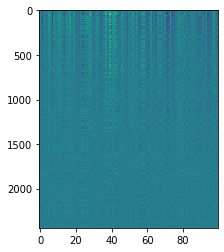

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(weights, interpolation='nearest')
ax.set_aspect(0.05)

In [29]:
vocab_set = set(vocab)
model_dict = dict(zip(vocab, weights))

## Calculate Embeddings for Tunes

For all ngrams in a tune, average the corresponding ngram embedding vectors to determine the tune embedding vector.

In [30]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector


def averaged_word_vectorizer(corpus, model, num_features):
  vocabulary = vocab_set

  features = []
  for tune in corpus:
    features.append(average_word_vectors(tune, 
                                         model, 
                                         vocabulary, 
                                         num_features)
    )

  return np.array(features)

In [31]:
# get document level embeddings
corpus = data_ngrams
num_features = EMBED_SIZE

ft_doc_features = averaged_word_vectorizer(corpus=corpus, 
                                           model=model_dict,
                                           num_features=num_features)

df_features = pd.DataFrame(ft_doc_features)

In [32]:
df_features.shape

(2046, 100)

In [33]:
df_features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.150182,-0.221290,-0.000956,0.034414,-0.064395,0.132233,-0.047038,-0.118847,0.185320,-0.008083,0.087392,0.265679,0.060218,0.065447,-0.019294,0.187505,-0.095762,0.229817,0.063495,0.143407,-0.118940,-0.065146,-0.048603,0.041446,0.170064,-0.003334,0.236153,0.167917,0.042439,-0.025795,-0.082797,0.086971,0.067012,0.032565,-0.149592,-0.054024,-0.114406,0.102429,0.105995,0.006999,...,-0.097418,0.149971,0.094828,-0.097916,0.094806,-0.125385,0.068085,-0.172817,0.008034,-0.102929,0.108977,-0.198752,-0.254369,0.160784,-0.104625,-0.086580,-0.119120,0.131353,0.105489,0.080933,0.160939,-0.085352,0.119030,-0.205268,-0.140438,-0.049761,0.072446,-0.035992,-0.183890,-0.192238,-0.152040,0.023913,-0.117319,0.030128,-0.144273,-0.115679,-0.078405,0.242414,-0.085414,-0.009535
1,0.383954,-0.351336,-0.072753,0.012612,-0.200076,0.383132,-0.074159,-0.412718,0.272323,-0.006430,0.119417,0.478784,0.110886,0.036913,-0.131900,0.261828,-0.115819,0.401109,0.018263,0.201690,-0.264480,-0.109471,-0.126730,0.113465,0.225955,0.061310,0.330483,0.181552,0.123760,0.034452,-0.348771,0.019423,0.084655,0.039059,-0.233753,-0.041566,-0.153733,0.271824,0.077009,0.217456,...,-0.251093,0.048081,0.121500,-0.277025,0.109028,-0.280516,0.119732,-0.250631,0.018537,-0.210904,0.218286,-0.389549,-0.454249,0.297599,-0.289519,-0.247144,-0.108541,0.091708,0.124850,0.071589,0.098542,-0.097104,0.152950,-0.391793,-0.119419,-0.045754,0.097373,-0.138943,-0.250960,-0.221483,-0.228810,0.024044,-0.229950,-0.056078,-0.353294,-0.222167,-0.196935,0.439475,-0.099616,-0.104724
2,0.258696,-0.168764,-0.029569,-0.048764,-0.153302,0.278299,-0.044848,-0.251062,0.217708,0.030862,0.075362,0.386872,0.049910,-0.009315,-0.048225,0.164898,-0.091793,0.237468,0.009338,0.163317,-0.185587,-0.069609,-0.083786,0.122056,0.225073,0.055859,0.222275,0.066994,0.061037,0.036521,-0.279189,0.048703,-0.081535,-0.031777,-0.101875,-0.066959,-0.239002,0.093106,0.043843,0.092078,...,-0.159145,0.107847,0.040490,-0.102012,0.149307,-0.255791,0.081615,-0.239094,-0.026826,-0.079543,0.198347,-0.138430,-0.296757,0.196625,-0.211995,-0.164602,-0.057135,0.034085,0.067764,0.048156,0.135903,-0.112830,0.151145,-0.297609,-0.152370,-0.085208,0.078177,-0.121807,-0.153540,-0.117971,-0.142682,0.047980,-0.089175,-0.014663,-0.228317,-0.120919,-0.140796,0.250868,-0.101303,-0.043757
3,0.190535,-0.257226,-0.097339,0.100110,-0.092230,0.295285,0.101243,-0.704100,0.009439,0.002448,0.229007,0.226909,0.163723,-0.229713,-0.237195,0.106970,0.079393,0.303427,-0.086455,0.142871,-0.010301,-0.011740,-0.220606,-0.064822,-0.406844,0.060751,0.037808,0.113138,0.408388,0.091317,-0.293090,-0.081652,0.258757,-0.004737,-0.318850,-0.152027,0.152825,0.472700,-0.058870,0.753688,...,-0.163440,-0.315452,0.347450,-0.146085,-0.031193,-0.361959,0.104983,0.168431,0.120048,-0.336520,0.039330,-0.555664,-0.268017,0.359890,-0.307770,-0.205134,-0.123795,0.171550,0.170782,0.072234,0.033333,0.096355,-0.078412,-0.142336,0.004541,-0.003509,0.089268,-0.022635,-0.134499,-0.215016,-0.168955,-0.004791,-0.377203,0.154330,-0.467502,-0.318636,-0.102476,0.396186,0.026064,-0.267307
4,0.089459,-0.094408,-0.085176,0.024259,-0.021213,0.081186,0.006937,-0.250834,0.016026,-0.067945,0.191746,0.100450,0.040756,-0.007639,0.008023,0.100754,0.009972,0.079758,-0.053585,0.046481,-0.125498,-0.004319,-0.105525,0.020171,-0.026088,0.038641,0.133257,0.141664,0.133213,0.012091,-0.040025,-0.035608,0.120762,-0.026513,-0.144843,-0.050159,-0.008638,0.090824,-0.056663,0.172900,...,-0.071181,-0.025364,0.116855,-0.026886,-0.021125,-0.100015,0.120073,0.070930,0.048750,-0.059428,0.092715,-0.197733,-0.108258,0.075515,-0.097366,-0.048413,-0.037414,0.070923,0.027935,0.016578,0.111222,-0.044347,-0.000533,-0.025265,0.045067,0.030141,0.008652,-0.071751,-0.034140,-0.022220,-0.129504,-0.036159,-0.

#### Visualize the average embedding vectors for each tune


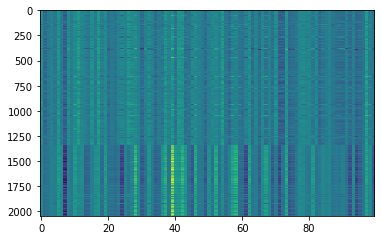

In [34]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(df_features, interpolation='nearest')
ax.set_aspect(0.03)

In [35]:
from sklearn.cluster import AffinityPropagation

ap = AffinityPropagation()
ap.fit(ft_doc_features)

cluster_labels = ap.labels_
cluster_labels = pd.DataFrame(cluster_labels, 
                              columns=['ClusterLabel'])
print(f"Number of Clusters: {max(ap.labels_)}")


Number of Clusters: 40


#### T-SNE of tunes based on Embeddings

In [36]:
assert(len(titles) == len(ft_doc_features))

In [37]:
tsne = TSNE(n_components=2, 
            random_state=0,
            perplexity = 70,
            learning_rate=100.0,
            #n_iter_without_progress=200,
            n_iter=5000
            )
#np.set_printoptions(suppress=True)
T = tsne.fit_transform(ft_doc_features)

In [38]:
projected = pd.DataFrame(T)
projected['tune'] = titles['title']
#projected['cluster'] = df_cluster['ClusterLabel'].astype(str)
projected['mode'] = meta['tune_mode']

fig = px.scatter(
    projected, 
    x=0, y=1,
    color='mode',
    hover_name='tune',
    width=600, height=500
)
fig.update_traces(textposition='top center')
fig.update_traces(textfont_size=8, selector=dict(type='scatter'))
fig.show()

### Cluster the T-SNE Result

In [39]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=8)
clusterer.fit(T)

clusterer.labels_

array([0, 0, 0, ..., 1, 1, 1])

In [40]:
clust_proj = pd.DataFrame(T)
clust_proj['tune'] = titles['title']
clust_proj['cluster'] = clusterer.labels_.astype(str)
clust_proj['mode'] = titles['tune_mode']

fig = px.scatter(
    clust_proj, 
    x=0, y=1,
    color='cluster',
    hover_name='tune',
    width=600, height=500
)
fig.update_traces(textposition='top center')
fig.update_traces(textfont_size=8, selector=dict(type='scatter'))
fig.show()

In [41]:
clust_proj

,0,1,tune,cluster,mode
0,0.369038,-21.690859,26-2,0,major
1,25.161869,-19.169052,500 Miles High,0,minor
2,7.016765,-26.625723,502 Blues,0,minor
3,-7.346190,12.926373,52nd Street Theme,1,major
4,-10.120907,-14.662303,9.20 Special,0,major
...,...,...,...,...,...
2041,-20.202587,23.385942,You're Foolin' Someone,1,major
2042,9.107729,-2.581983,You're Lucky To Me,0,major
2043,-12.057614,12.463738,You're Nobody Till Somebody Loves You,1,major
2044,-25.045858,36.927750,Your Feet's Too Big,1,major


#### Histograms for ngrams for each Cluster

In [42]:
def plot_cluster_histograms(df, cluster, top_n=45):
  tune_ind = df.query(f'cluster=="{cluster}"').index
  tune_ind

  # filter the tunes
  tune_chords = [ data_ngrams[i] for i in tune_ind ]

  # flatten the filtered tunes
  tune_chords = [item for tune in tune_chords for item in tune]

  counts = Counter(tune_chords)
  df_chords = pd.DataFrame(counts.items(),
                      columns=['chord_ngram', 'count']).sort_values(by='count', ascending=False)

  df_chords = pd.DataFrame.from_dict(df_chords[:top_n])
  df_chords.sort_values(by=['count'], ascending=False, inplace=True)

  fig = px.bar(df_chords, x='chord_ngram', y='count', log_y=True, title=f"Cluster {cluster}")
  fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
  fig.show()

In [43]:
plot_cluster_histograms(clust_proj, cluster=0)

In [44]:
plot_cluster_histograms(clust_proj, cluster=1)

In [45]:
plot_cluster_histograms(clust_proj, cluster=2)

### Similarity Tree

In [46]:
import networkx as nx
from collections import deque

def sim_tree(model, word, top_n, max_dist):

    graph = nx.Graph()
    graph.add_node(word, dist=0)

    to_visit = deque([word])
    while len(to_visit) > 0:
        source = to_visit.popleft() # visit next node
        dist = graph.nodes[source]['dist']+1

        if dist <= max_dist: # discover new nodes
            for target, sim in model.most_similar(source, topn=top_n):
                if target not in graph:
                    to_visit.append(target)
                    graph.add_node(target, dist=dist)
                    graph.add_edge(source, target, sim=sim, dist=dist)
    return graph

In [47]:
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt

def plot_tree(graph, node_size=1000, font_size=8):

    pos = graphviz_layout(graph, prog='twopi', root=list(graph.nodes)[0])

    colors = [graph.nodes[n]['dist'] for n in graph] # colorize by distance
    nx.draw_networkx_nodes(graph, pos, node_size=node_size, node_color=colors,
                           cmap='Set1', alpha=0.4)
    nx.draw_networkx_labels(graph, pos, font_size=font_size)

    for (n1, n2, sim) in graph.edges(data='sim'):
         nx.draw_networkx_edges(graph, pos, [(n1, n2)], width=sim, alpha=0.2)
    
    plt.rcParams["figure.figsize"] = (10,5)
    plt.show()


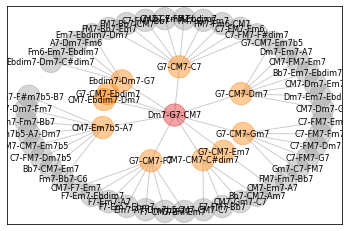

In [48]:
graph = sim_tree(model.wv, 'Dm7-G7-CM7', top_n=10, max_dist=2)
plot_tree(graph, node_size=500, font_size=8)

## Cosine Similarity between Tunes

In [49]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([ft_doc_features[0]], [ft_doc_features[1]])

array([[0.92784131]])

In [50]:
df_cos = pd.DataFrame(cosine_similarity(ft_doc_features),
                      columns=titles['title'],
                      index=titles['title'])
df_cos

title,26-2,500 Miles High,502 Blues,52nd Street Theme,9.20 Special,A Ballad,A Beautiful Friendship,A Blossom Fell,A Certain Smile,A Child Is Born,A Felicidade,A Fine Romance,A Flower Is A Lovesome Thing,A Foggy Day,A Ghost Of A Chance,A Kiss To Build A Dream On,A Little Tear,A Lovely Way To Spend An Evening,A Night In Tunisia,A Nightingale Sang In Berkeley Square,A Pretty Girl Is Like A Melody,A Sleepin' Bee,A Smooth One,A Sound For Sore Ears,A Sunday Kind Of Love,A Taste Of Honey,A Time For Love,A Tisket A Tasket,A Weaver Of Dreams,A Wonderful Day Like Today,Ablution,Ac-Cent-Tchu-Ate The Positive,Across The Alley From The Alamo,Adam's Apple,Affirmation,"African Queen, The",Afro Blue,Afro Centric,After You've Gone,After You,...,When Your Hair Has Turned To Silver,Whenever You're Lonesome,Where He Leads Me,Where The Saviour Leads Me,While We Danced At The Mardi Gras,Whispering,"White Cliffs Of Dover, The","White Sport Coat And A Pink Carnation, A",Who's Sorry Now,Why Don't You Go Down To New Orleans,Wild Man Blues,Willie The Weeper,Winin' Boy Blues,Wish Me Luck As You Wave Me Goodbye,"Without You For An Inspiration, Dear",Wolverine Blues,Wooden Heart,Working Man Blues,Wrap Your Troubles In Dreams,Yama Yama Man,Yearning,Yellow Dog Blues,"Yes Sir, That's My Baby",Yes! We Have No Bananas,You Always Hurt The One You Love,You Are My Sunshine,You Belong To Me,You Broke Your Promise,You Can Depend On Me,You Meet The Nicest People In Your Dreams,You Must Have Been A Beautiful Baby,"You Tell Me Your Dreams, I'll Tell You Mine",You Were Only Fooling,You're A Real Sweetheart,You're Driving Me Crazy,You're Foolin' Someone,You're Lucky To Me,You're Nobody Till Somebody Loves You,Your Feet's Too Big,Zing Went The Strings Of My Heart
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
26-2,1.000000,0.927841,0.905895,0.493821,0.618030,0.968574,0.929046,0.836938,0.919198,0.727067,0.936313,0.925139,0.757348,0.944569,0.955389,0.926177,0.871014,0.949539,0.724153,0.962049,0.880488,0.868659,0.635006,0.399854,0.953984,0.796666,0.873989,0.925241,0.931936,0.923654,0.963301,0.928659,0.868557,0.394459,0.821860,0.492227,0.328185,0.865296,0.919875,0.937008,...,0.284189,0.248617,0.243873,0.266132,0.296293,0.210148,0.170497,0.232091,0.342727,0.257605,0.201154,0.261425,0.237476,0.292821,0.305833,0.226202,0.276493,0.270565,0.218217,0.280934,0.247673,0.216043,0.267963,0.249221,0.173911,0.266730,0.135640,0.226374,0.940263,0.288170,0.264225,0.238130,0.223662,0.225363,0.181345,0.235391,0.684554,0.298824,0.247178,0.154292
500 Miles High,0.927841,1.000000,0.948906,0.664806,0.721983,0.967487,0.976564,0.928568,0.978038,0.885666,0.993025,0.967913,0.868681,0.975626,0.979558,0.944114,0.961127,0.982326,0.841585,0.982190,0.964829,0.962026,0.626902,0.599717,0.975365,0.921521,0.959705,0.971200,0.993009,0.973866,0.982621,0.965923,0.948703,0.490689,0.906508,0.584955,0.424036,0.893156,0.977756,0.986711,...,0.496374,0.467102,0.457375,0.478171,0.505971,0.426456,0.388227,0.447115,0.553666,0.471155,0.431128,0.486213,0.455532,0.506487,0.511902,0.441955,0.488101,0.482291,0.445084,0.492834,0.459406,0.429085,0.480761,0.462323,0.390787,0.477512,0.355404,0.444992,0.969030,0.499767,0.480445,0.458121,0.443212,0.440575,0.402565,0.449238,0.839430,0.509928,0.459624,0.377592
502 Blues,0.905895,0.948906,1.000000,0.503955,0.603893,0.910989,0.888101,0.798725,0.900946,0.859166,0.964744,0.874968,0.734167,0.891396,0.909651,0.911240,0.853574,0.917645,0.829178,0.935116,0.865872,0.863195,0.589473,0.460558,0.897694,0.879728,0.979226,0.879183,0.956402,0.880894,0.933166,0.876977,0.863853,0.392756,0.891348,0.591618,0.499814,0.867391,0.888665,0.922797,...,0.339561,0.306401,0.300067,0.324744,0.349469,0.263764,0.225986,0.291536,0.391405,0.317275,0.285800,0.366778,0.297911,0.354774,0.345717,0.284445,0.334050,0.325510,0.292813,0.338136,0.304224,0.271292,0.326044,0.301231,0.234180,0.322393,0.199632,0.292401,0.883580,0.343392,0.324985,0.301040,0.288904,0.284887,0.243921,0.287136

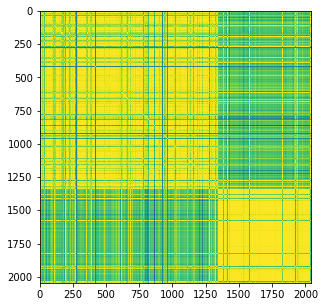

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(df_cos, interpolation='nearest')
ax.set_aspect(1)

In [52]:
def get_similar_tunes(df, threshold = 0.9):
  # display tunes that have a cos_sim value bigger than the threshold

  # create a series of tunes containing a list of similar tunes for each tune
  cols = df.columns
  bt = df.apply(lambda x: x > threshold)
  result = bt.apply(lambda x: list(cols[x.values]), axis=1)

  # print the result
  tuneA = []
  tuneB = []
  cos_val = []

  for idx, val in tqdm(result.iteritems()):
    # if the tune is similar to other tunes
    if len(val) <= 1:
      continue
    #print(f'{idx}')
    for tune in val:
      if tune != idx:
        #print(f'\t{df.loc[idx][tune]:.3f} - {tune}')
        tuneA.append(idx)
        tuneB.append(tune)
        cos_val.append(df.loc[idx][tune])

  df_result = pd.DataFrame(list(zip(tuneA,
                                    tuneB,
                                    cos_val)),
                           columns=['tuneA', 'tuneB', 'cos_val']
                           )
  df_result.sort_values(['tuneA', 'cos_val'], ascending=[True, False], inplace=True)
  return df_result

In [53]:
# threshold for the cosinus similarity value to display
COS_THRES = 0.8

In [54]:
nn = 100 # limit the number of tunes to speed up

df_result_chords = get_similar_tunes(df_cos.iloc[0:nn,0:nn], 
                                     threshold=COS_THRES)

100it [00:00, 135.03it/s]


In [55]:
df_result_chords['tuneA'].unique()

array(['26-2', '500 Miles High', '502 Blues', '52nd Street Theme',
       '9.20 Special', 'A Ballad', 'A Beautiful Friendship',
       'A Blossom Fell', 'A Certain Smile', 'A Child Is Born',
       'A Felicidade', 'A Fine Romance', 'A Flower Is A Lovesome Thing',
       'A Foggy Day', 'A Ghost Of A Chance', 'A Kiss To Build A Dream On',
       'A Little Tear', 'A Lovely Way To Spend An Evening',
       'A Night In Tunisia', 'A Nightingale Sang In Berkeley Square',
       'A Pretty Girl Is Like A Melody', "A Sleepin' Bee",
       'A Sound For Sore Ears', 'A Sunday Kind Of Love',
       'A Taste Of Honey', 'A Time For Love', 'A Tisket A Tasket',
       'A Weaver Of Dreams', 'A Wonderful Day Like Today', 'Ablution',
       'Ac-Cent-Tchu-Ate The Positive', 'Across The Alley From The Alamo',
       "Adam's Apple", 'Affirmation', 'Afro Centric', 'After You',
       "After You've Gone", 'Afternoon In Paris', 'Again',
       'Agua De Beber', 'Ahmid-6', "Ain't Misbehavin'", "Ain't She Sweet",
 

In [56]:
df_result_chords.query('tuneA == "Autumn Leaves"').reset_index()

,index,tuneA,tuneB,cos_val
0,6619,Autumn Leaves,Alone Together,0.991357
1,6583,Autumn Leaves,A Time For Love,0.980520
2,6564,Autumn Leaves,502 Blues,0.973047
3,6570,Autumn Leaves,A Felicidade,0.965327
4,6599,Autumn Leaves,Airegin,0.964666
...,...,...,...,...
76,6591,Autumn Leaves,Afro Centric,0.856898
77,6641,Autumn Leaves,Autumn Nocturne,0.850878
78,6634,Autumn Leaves,Armando's Rhumba,0.845340
79,6632,Autumn Leaves,April,0.838837


# Doc2Vec Embeddings


In [57]:
import smart_open

def read_corpus(fname, tokens_only=False):
    with smart_open.open(fname, encoding="iso-8859-1") as f:
        for i, line in enumerate(f):
            tokens = ngrams(line.split(), 4, '-')
            if tokens_only:
                yield tokens
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

In [58]:
train_corpus = list(read_corpus(path_to_file))
train_corpus[:10]

[TaggedDocument(words=['CM7-Eb7-G#M7-B7', 'Eb7-G#M7-B7-EM7', 'G#M7-B7-EM7-G7', 'B7-EM7-G7-Gm7', 'EM7-G7-Gm7-C7', 'G7-Gm7-C7-FM7', 'Gm7-C7-FM7-G#7', 'C7-FM7-G#7-C#M7', 'FM7-G#7-C#M7-E7', 'G#7-C#M7-E7-Am7', 'C#M7-E7-Am7-D7', 'E7-Am7-D7-Dm7', 'Am7-D7-Dm7-G7', 'D7-Dm7-G7-CM7', 'Dm7-G7-CM7-Eb7', 'G7-CM7-Eb7-G#M7', 'CM7-Eb7-G#M7-B7', 'Eb7-G#M7-B7-EM7', 'G#M7-B7-EM7-G7', 'B7-EM7-G7-Gm7', 'EM7-G7-Gm7-C7', 'G7-Gm7-C7-FM7', 'Gm7-C7-FM7-Eb7', 'C7-FM7-Eb7-G#M7', 'FM7-Eb7-G#M7-B7', 'Eb7-G#M7-B7-EM7', 'G#M7-B7-EM7-G7', 'B7-EM7-G7-CM7', 'EM7-G7-CM7-Gm7', 'G7-CM7-Gm7-C7', 'CM7-Gm7-C7-Bm7', 'Gm7-C7-Bm7-E7', 'C7-Bm7-E7-AM7', 'Bm7-E7-AM7-C7', 'E7-AM7-C7-FM7', 'AM7-C7-FM7-Bbm7', 'C7-FM7-Bbm7-Eb7', 'FM7-Bbm7-Eb7-G#M7', 'Bbm7-Eb7-G#M7-Dm7', 'Eb7-G#M7-Dm7-G7', 'G#M7-Dm7-G7-CM7', 'Dm7-G7-CM7-Eb7', 'G7-CM7-Eb7-G#M7', 'CM7-Eb7-G#M7-B7', 'Eb7-G#M7-B7-EM7', 'G#M7-B7-EM7-G7', 'B7-EM7-G7-Gm7', 'EM7-G7-Gm7-C7', 'G7-Gm7-C7-FM7', 'Gm7-C7-FM7-Eb7', 'C7-FM7-Eb7-G#M7', 'FM7-Eb7-G#M7-B7', 'Eb7-G#M7-B7-EM7', 'G#M7-B7-EM7-G

Now, we’ll instantiate a Doc2Vec model with a vector size with 50 dimensions and iterating over the training corpus 40 times. 

In [59]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, 
                                      window=2,
                                      min_count=5, 
                                      sample = 0.1, # threshold for configuring which higher-frequency words are randomly downsampled
                                      epochs=40,
                                      )

2021-11-09 08:33:21,200 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec(dm/m,d100,n5,w2,mc5,s0.1,t3)', 'datetime': '2021-11-09T08:33:21.200035', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'created'}


Build a vocabulary:

In [60]:
model.build_vocab(train_corpus)

2021-11-09 08:33:21,220 : INFO : collecting all words and their counts
2021-11-09 08:33:21,225 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2021-11-09 08:33:21,263 : INFO : collected 24901 word types and 2046 unique tags from a corpus of 2046 examples and 87492 words
2021-11-09 08:33:21,265 : INFO : Creating a fresh vocabulary
2021-11-09 08:33:21,294 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=5 retains 2824 unique words (11.340910003614313%% of original 24901, drops 22077)', 'datetime': '2021-11-09T08:33:21.294291', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'prepare_vocab'}
2021-11-09 08:33:21,296 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 53505 word corpus (61.15416266630092%% of original 87492, drops 33987)', 'datetime': '2021-11-09T08:33:21.296386', 'gensim': '4.1.2', 'python': '3.7.12 (de

In [62]:
model.train(train_corpus, 
            total_examples=model.corpus_count, 
            epochs=model.epochs)

2021-11-09 08:35:03,952 : INFO : Doc2Vec lifecycle event {'msg': 'training model with 3 workers on 2824 vocabulary and 100 features, using sg=0 hs=0 sample=0.1 negative=5 window=2 shrink_windows=True', 'datetime': '2021-11-09T08:35:03.951938', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'train'}
2021-11-09 08:35:04,290 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-11-09 08:35:04,305 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11-09 08:35:04,312 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-09 08:35:04,313 : INFO : EPOCH - 1 : training on 87492 raw words (55551 effective words) took 0.3s, 161248 effective words/s
2021-11-09 08:35:04,627 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-11-09 08:35:04,639 : INFO : worker thread finished; awaiting finish of 1 more threads
20

## Assessing the Model

To assess our new model, we’ll first infer new vectors for each document of the training corpus, compare the inferred vectors with the training corpus, and then returning the rank of the document based on self-similarity. Basically, we’re pretending as if the training corpus is some new unseen data and then seeing how they compare with the trained model. The expectation is that we’ve likely overfit our model (i.e., all of the ranks will be less than 2) and so we should be able to find similar documents very easily. Additionally, we’ll keep track of the second ranks for a comparison of less similar documents.

In [63]:
ranks = []
second_ranks = []
similarities = []

assess_corpus = train_corpus

for doc_id in range(len(assess_corpus)):
    inferred_vector = model.infer_vector(train_corpus[doc_id].words)
    sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
    similarities.append(sims)
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])

Let’s count how each document ranks with respect to the training corpus

NB. Results vary between runs due to random seeding and very small corpus.

Example: `Counter({0: 46, 15: 1, 4: 1, 2: 1, 23: 1})` means: 46 documents are most similar to themselves -> that's the ideal case. 1 document is similar to 15 other documents before it is recognized as similar to itself, etc.

In [64]:
import collections

counter = collections.Counter(ranks)
print(counter)

tunes_sim = counter[0]
tunes_not_sim = len(assess_corpus) - counter[0]

print()
print(f"Tunes similar to themselves in first place: {tunes_sim}")
print(f"Tunes not similar in first place: {tunes_not_sim}")
print(f"% of tunes not similar to themselves in first place: {100 * tunes_not_sim/tunes_sim:.2f}%")

Counter({0: 1638, 1: 91, 2: 37, 3: 21, 4: 14, 6: 13, 5: 11, 7: 7, 8: 7, 50: 7, 11: 6, 19: 5, 15: 5, 9: 5, 14: 4, 26: 4, 33: 4, 20: 4, 24: 3, 22: 3, 186: 3, 49: 3, 12: 3, 10: 3, 53: 3, 41: 3, 16: 3, 18: 2, 42: 2, 44: 2, 25: 2, 56: 2, 21: 2, 167: 2, 29: 2, 43: 2, 99: 2, 27: 2, 23: 2, 66: 2, 13: 2, 61: 2, 30: 2, 87: 2, 34: 2, 60: 2, 62: 1, 179: 1, 154: 1, 508: 1, 1205: 1, 1757: 1, 621: 1, 69: 1, 57: 1, 96: 1, 267: 1, 191: 1, 67: 1, 88: 1, 1168: 1, 481: 1, 1095: 1, 1924: 1, 1498: 1, 518: 1, 547: 1, 139: 1, 1448: 1, 1410: 1, 127: 1, 426: 1, 1912: 1, 1741: 1, 2045: 1, 1539: 1, 500: 1, 357: 1, 1591: 1, 2022: 1, 1007: 1, 52: 1, 839: 1, 974: 1, 736: 1, 330: 1, 1500: 1, 1961: 1, 274: 1, 1145: 1, 135: 1, 76: 1, 600: 1, 1787: 1, 197: 1, 1944: 1, 28: 1, 1995: 1, 1803: 1, 741: 1, 290: 1, 2031: 1, 988: 1, 934: 1, 1564: 1, 2008: 1, 136: 1, 259: 1, 394: 1, 1010: 1, 254: 1, 221: 1, 177: 1, 494: 1, 36: 1, 71: 1, 172: 1, 48: 1, 38: 1, 171: 1, 187: 1, 31: 1, 39: 1, 46: 1, 128: 1, 300: 1, 45: 1, 328: 1, 204

In [65]:
#pos = list(counter.keys())[1]
pos = max(list(counter.keys()))

index = ranks.index(pos)
print(f"pos: {pos}, at index: {index}")
print(f"The tune '{titles.iloc[index, 0]}' is similar to {pos} other tunes before it is similar to itself:")

for i in range(pos+1):
  sim_index = similarities[index][i][0]
  sim_value = similarities[index][i][1]
  print(f"\t{titles.iloc[sim_index, 0]}, {sim_value:.3f}")

pos: 2045, at index: 610
The tune 'Iris' is similar to 2045 other tunes before it is similar to itself:
	So Tender, 0.179
	Sweeping Up, 0.158
	Look To The Rainbow, 0.155
	Bright Size Life, 0.150
	Breeze And I, The, 0.142
	You Won't Forget Me, 0.138
	Fantasy in D (or Ugetsu), 0.137
	He's A Tramp, 0.137
	Back In Your Own Backyard, 0.137
	Fools Rush In, 0.132
	It's A Raggy Waltz, 0.129
	Prism, 0.128
	Kiss To Build A Dream On , A, 0.127
	Rockin' Chair, 0.126
	Sporting Life Blues, 0.125
	Down In The Depths, 0.115
	Better Git It In Your Soul, 0.115
	Of All The Wrongs You've Done To Me, 0.113
	Nevertheless (I'm In Love With You), 0.113
	Fair And Square In Love, 0.113
	Fidgety Feet (War Clouds), 0.112
	Ol' Man River, 0.111
	I Wish I Could Shimmy Like My Sister Kate, 0.109
	They Say, 0.109
	Panama, 0.107
	My Way, 0.107
	Tie Me To Your Apron Strings Again, 0.107
	While We Danced At The Mardi Gras, 0.106
	Horace-Scope, 0.105
	Gloria's Step, 0.105
	Heyoke, 0.097
	Thelonious, 0.095
	Blueberry Hill,

## Hyperparameters for Word2Vec

In [66]:
!mkdir models_word2vec

In [67]:
model_path = './models_word2vec'
model_prefix = 'autos'

param_grid = {'w2v': {'variant': ['cbow', 'sg'], 'window': [2, 3, 4, 10]},
              'ft': {'variant': ['sg'], 'window': [5]}}
size = 100

for algo, params in param_grid.items():
    for variant in params['variant']:
        sg = 1 if variant == 'sg' else 0
        for window in params['window']:
            if algo == 'w2v':
                model = gensim.models.Word2Vec(data_ngrams, vector_size=size, window=window, sg=sg, epochs=5)
            else:
                model = gensim.models.FastText(data_ngrams, vector_size=size, window=window, sg=sg, epochs=5)

            file_name = f"{model_path}/{model_prefix}_{algo}_{variant}_{window}"
            model.wv.save_word2vec_format(file_name + '.bin', binary=True)



2021-11-09 08:35:41,844 : INFO : collecting all words and their counts
2021-11-09 08:35:41,846 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-11-09 08:35:41,870 : INFO : collected 13442 word types from a corpus of 89538 raw words and 2046 sentences
2021-11-09 08:35:41,874 : INFO : Creating a fresh vocabulary
2021-11-09 08:35:41,899 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 2440 unique words (18.152060705252193%% of original 13442, drops 11002)', 'datetime': '2021-11-09T08:35:41.899834', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'prepare_vocab'}
2021-11-09 08:35:41,901 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 71559 word corpus (79.92025732091402%% of original 89538, drops 17979)', 'datetime': '2021-11-09T08:35:41.901415', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021,

### Evaluating the different Models


In [68]:
from gensim.models import KeyedVectors

names = ['autos_w2v_cbow_2', 'autos_w2v_sg_2',
         'autos_w2v_cbow_3', 'autos_w2v_sg_3',
         'autos_w2v_cbow_4', 'autos_w2v_sg_4',
         'autos_w2v_cbow_10', 'autos_w2v_sg_10',
         ]
models = {}

for name in names:
    file_name = f"{model_path}/{name}.bin"
    models[name] = KeyedVectors.load_word2vec_format(file_name, binary=True)

2021-11-09 08:35:58,678 : INFO : loading projection weights from ./models_word2vec/autos_w2v_cbow_2.bin
2021-11-09 08:35:58,715 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (2440, 100) matrix of type float32 from ./models_word2vec/autos_w2v_cbow_2.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2021-11-09T08:35:58.715246', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'load_word2vec_format'}
2021-11-09 08:35:58,717 : INFO : loading projection weights from ./models_word2vec/autos_w2v_sg_2.bin
2021-11-09 08:35:58,750 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (2440, 100) matrix of type float32 from ./models_word2vec/autos_w2v_sg_2.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2021-11-09T08:35:58.749893', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bi

In [69]:
models

{'autos_w2v_cbow_10': <gensim.models.keyedvectors.KeyedVectors at 0x7f7a9c868ed0>,
 'autos_w2v_cbow_2': <gensim.models.keyedvectors.KeyedVectors at 0x7f7a9f341d50>,
 'autos_w2v_cbow_3': <gensim.models.keyedvectors.KeyedVectors at 0x7f7a9c952050>,
 'autos_w2v_cbow_4': <gensim.models.keyedvectors.KeyedVectors at 0x7f7a9c909390>,
 'autos_w2v_sg_10': <gensim.models.keyedvectors.KeyedVectors at 0x7f7a9c86a0d0>,
 'autos_w2v_sg_2': <gensim.models.keyedvectors.KeyedVectors at 0x7f7a9f3b5f10>,
 'autos_w2v_sg_3': <gensim.models.keyedvectors.KeyedVectors at 0x7f7a9c9095d0>,
 'autos_w2v_sg_4': <gensim.models.keyedvectors.KeyedVectors at 0x7f7a9c879250>}

In [70]:
def compare_models(models, **kwargs):

    df = pd.DataFrame()
    for name, model in models:
        df[name] = [f"{word} {score:.3f}"
                    for word, score in model.most_similar(**kwargs)]
    df.index = df.index + 1 # let row index start at 1
    return df

In [71]:
compare_models([(n, models[n]) for n in names], positive='CM7-Dm7-G7', topn=10)

,autos_w2v_cbow_2,autos_w2v_sg_2,autos_w2v_cbow_3,autos_w2v_sg_3,autos_w2v_cbow_4,autos_w2v_sg_4,autos_w2v_cbow_10,autos_w2v_sg_10
1,G7-CM7-Dm7 0.972,CM7-Dm7-Ebdim7 0.936,G7-CM7-Dm7 0.982,CM7-Dm7-Ebdim7 0.941,G7-CM7-Dm7 0.985,CM7-Dm7-Ebdim7 0.920,G7-CM7-Dm7 0.983,CM7-CM7-Dm7 0.833
2,CM7-CM7-Dm7 0.970,G#M7-Dm7-G7 0.925,Dm7-G7-CM7 0.976,G#M7-Dm7-G7 0.919,G7-CM7-CM7 0.983,CM7-D7-Dm7 0.917,G7-CM7-CM7 0.983,F#dim7-CM7-Dm7 0.832
3,Dm7-G7-CM7 0.966,CM7-Dm7-Em7 0.925,G7-CM7-CM7 0.972,G7-CM7-Cm7 0.918,Dm7-G7-CM7 0.968,CM7-CM7-Dm7 0.910,F#dim7-CM7-Dm7 0.977,G7-CM7-Dm7 0.832
4,G7-CM7-CM7 0.966,G7-CM7-Cm7 0.920,CM7-CM7-Dm7 0.965,C6-CM7-Dm7 0.912,CM7-CM7-Dm7 0.963,G7-CM7-D7 0.904,CM7-G7-CM7 0.977,CM7-C-C6 0.826
5,CM7-Dm7-Em7 0.949,CM7-CM7-Em7b5 0.917,G7-CM7-C#dim7 0.959,CM7-CM7-Dm7 0.912,G7-CM7-C#dim7 0.953,C6-CM7-Dm7 0.901,Am6-Dm7-G7 0.975,Dm7-Em7-G7 0.818
6,G7-CM7-C#dim7 0.947,CM7-CM7-Dm7 0.916,CM7-C#dim7-Dm7 0.957,G7-CM7-F#m7 0.911,CM7-C#dim7-Dm7 0.951,G7-CM7-Dm7 0.898,G7-CM7-G7 0.974,CM7-A7-FM7 0.816
7,G7-CM7-FM7 0.941,G7-CM7-Dm7 0.914,CM7-Dm7-Em7 0.954,CM7-D7-Dm7 0.909,CM7-Dm7-Em7 0.941,G7-CM7-C6 0.897,CM7-CM7-Ebm7 0.967,EM7-EM7-EM7 0.798
8,C#dim7-Dm7-G7 0.937,G7-CM7-B7 0.911,C#dim7-Dm7-G7 0.947,G7-CM7-Fm7 0.906,CM7-G7-CM7 0.940,CM7-CM7-Em7b5 0.894,CM7-C#dim7-Dm7 0.965,CM7-Dm7-Ebdim 0.797
9,CM7-C#dim7-Dm7 0.934,Dm7-CM7-Dm7 0.910,G7-CM7-Em7b5 0.946,G7-CM7-Dm7 0.905,G7-CM7-G7 0.939,G7-CM7-B7 0.894,Dm7-G7-CM7 0.964,Dm7-Ebdim-Em7 0.796
10,G7-CM7-C7 0.932,EbM7-Dm7-G7 0.910,G7-CM7-G7 0.946,CM7-Dm7-Ebdim 0.903,CM7-FM7-Em7 0.937,CM7-C-C6 0.892,G7-CM7-F7 0.957,C6-CM7-Dm7 0.793


## Doc2Vec Hyperparameters

In [72]:
!mkdir models_doc2vec

In [73]:
model_path = './models_doc2vec'
model_prefix = 'autos'

param_grid = {'d2v': {'variant': ['pv-dm', 'pv-dbow'], 
                      'window': [2, 3, 4, 10],
                      'sample': [0.001, 0.01, 0.1, 1.],
                     }
              }
size = 100
epochs = 50
sample = 0.1

for algo, params in param_grid.items():
    for variant in params['variant']:
        dm = 1 if variant == 'pv-dm' else 0
        for window in params['window']:
            for sample in params['sample']:
                if algo == 'd2v':
                    model = gensim.models.doc2vec.Doc2Vec(vector_size=size, 
                                                          window=window,
                                                          dm = dm,
                                                          min_count=5, 
                                                          sample = sample, # threshold for configuring which higher-frequency words are randomly downsampled
                                                          epochs=epochs,
                                                          )
                    model.build_vocab(train_corpus)
                    model.train(train_corpus, 
                                total_examples=model.corpus_count, 
                                epochs=model.epochs)

                else:
                    model = gensim.models.FastText(data_ngrams, vector_size=size, window=window, sg=sg, epochs=50)

                file_name = f"{model_path}/{model_prefix}_{algo}_{variant}_{window}_{sample}"
                model.save(file_name + '.bin')

Streaming output truncated to the last 5000 lines.
2021-11-09 08:38:57,879 : INFO : EPOCH - 49 : training on 87492 raw words (51346 effective words) took 0.4s, 117832 effective words/s
2021-11-09 08:38:58,214 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-11-09 08:38:58,231 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11-09 08:38:58,244 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-09 08:38:58,251 : INFO : EPOCH - 50 : training on 87492 raw words (51277 effective words) took 0.4s, 143604 effective words/s
2021-11-09 08:38:58,255 : INFO : Doc2Vec lifecycle event {'msg': 'training on 4374600 raw words (2566455 effective words) took 19.7s, 130198 effective words/s', 'datetime': '2021-11-09T08:38:58.255052', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'train'}
2021-11-09 08:38:58,262 : INFO : Doc2Ve

In [74]:
from gensim.models import KeyedVectors

from os import listdir
from os.path import isfile, join

names = [f for f in listdir(model_path) if isfile(join(model_path, f))]

models = {}

for name in names:
    file_name = f"{model_path}/{name}"
    print(file_name)
    models[name] = Doc2Vec.load(file_name)

2021-11-09 08:43:57,811 : INFO : loading Doc2Vec object from ./models_doc2vec/autos_d2v_pv-dbow_4_0.001.bin
2021-11-09 08:43:57,829 : INFO : loading dv recursively from ./models_doc2vec/autos_d2v_pv-dbow_4_0.001.bin.dv.* with mmap=None
2021-11-09 08:43:57,832 : INFO : loading wv recursively from ./models_doc2vec/autos_d2v_pv-dbow_4_0.001.bin.wv.* with mmap=None
2021-11-09 08:43:57,837 : INFO : setting ignored attribute cum_table to None
2021-11-09 08:43:57,921 : INFO : Doc2Vec lifecycle event {'fname': './models_doc2vec/autos_d2v_pv-dbow_4_0.001.bin', 'datetime': '2021-11-09T08:43:57.921080', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'loaded'}
2021-11-09 08:43:57,926 : INFO : loading Doc2Vec object from ./models_doc2vec/autos_d2v_pv-dm_4_0.1.bin
2021-11-09 08:43:57,935 : INFO : loading dv recursively from ./models_doc2vec/autos_d2v_pv-dm_4_0.1.bin.dv.* with mmap=None
2021-

./models_doc2vec/autos_d2v_pv-dbow_4_0.001.bin
./models_doc2vec/autos_d2v_pv-dm_4_0.1.bin
./models_doc2vec/autos_d2v_pv-dm_10_1.0.bin


2021-11-09 08:43:58,047 : INFO : Doc2Vec lifecycle event {'fname': './models_doc2vec/autos_d2v_pv-dm_10_1.0.bin', 'datetime': '2021-11-09T08:43:58.047844', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'loaded'}
2021-11-09 08:43:58,050 : INFO : loading Doc2Vec object from ./models_doc2vec/autos_d2v_pv-dm_2_0.01.bin
2021-11-09 08:43:58,062 : INFO : loading dv recursively from ./models_doc2vec/autos_d2v_pv-dm_2_0.01.bin.dv.* with mmap=None
2021-11-09 08:43:58,064 : INFO : loading wv recursively from ./models_doc2vec/autos_d2v_pv-dm_2_0.01.bin.wv.* with mmap=None
2021-11-09 08:43:58,065 : INFO : setting ignored attribute cum_table to None
2021-11-09 08:43:58,110 : INFO : Doc2Vec lifecycle event {'fname': './models_doc2vec/autos_d2v_pv-dm_2_0.01.bin', 'datetime': '2021-11-09T08:43:58.109960', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'pl

./models_doc2vec/autos_d2v_pv-dm_2_0.01.bin
./models_doc2vec/autos_d2v_pv-dbow_2_0.01.bin
./models_doc2vec/autos_d2v_pv-dbow_2_0.001.bin
./models_doc2vec/autos_d2v_pv-dbow_10_1.0.bin


2021-11-09 08:43:58,285 : INFO : Doc2Vec lifecycle event {'fname': './models_doc2vec/autos_d2v_pv-dbow_10_1.0.bin', 'datetime': '2021-11-09T08:43:58.285852', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'loaded'}
2021-11-09 08:43:58,288 : INFO : loading Doc2Vec object from ./models_doc2vec/autos_d2v_pv-dbow_4_1.0.bin
2021-11-09 08:43:58,299 : INFO : loading dv recursively from ./models_doc2vec/autos_d2v_pv-dbow_4_1.0.bin.dv.* with mmap=None
2021-11-09 08:43:58,301 : INFO : loading wv recursively from ./models_doc2vec/autos_d2v_pv-dbow_4_1.0.bin.wv.* with mmap=None
2021-11-09 08:43:58,303 : INFO : setting ignored attribute cum_table to None
2021-11-09 08:43:58,340 : INFO : Doc2Vec lifecycle event {'fname': './models_doc2vec/autos_d2v_pv-dbow_4_1.0.bin', 'datetime': '2021-11-09T08:43:58.340874', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]

./models_doc2vec/autos_d2v_pv-dbow_4_1.0.bin
./models_doc2vec/autos_d2v_pv-dm_2_0.1.bin
./models_doc2vec/autos_d2v_pv-dm_4_1.0.bin
./models_doc2vec/autos_d2v_pv-dbow_4_0.01.bin


2021-11-09 08:43:58,521 : INFO : Doc2Vec lifecycle event {'fname': './models_doc2vec/autos_d2v_pv-dbow_4_0.01.bin', 'datetime': '2021-11-09T08:43:58.521815', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'loaded'}
2021-11-09 08:43:58,523 : INFO : loading Doc2Vec object from ./models_doc2vec/autos_d2v_pv-dm_4_0.001.bin
2021-11-09 08:43:58,535 : INFO : loading dv recursively from ./models_doc2vec/autos_d2v_pv-dm_4_0.001.bin.dv.* with mmap=None
2021-11-09 08:43:58,539 : INFO : loading wv recursively from ./models_doc2vec/autos_d2v_pv-dm_4_0.001.bin.wv.* with mmap=None
2021-11-09 08:43:58,541 : INFO : setting ignored attribute cum_table to None
2021-11-09 08:43:58,577 : INFO : Doc2Vec lifecycle event {'fname': './models_doc2vec/autos_d2v_pv-dm_4_0.001.bin', 'datetime': '2021-11-09T08:43:58.577630', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]

./models_doc2vec/autos_d2v_pv-dm_4_0.001.bin
./models_doc2vec/autos_d2v_pv-dm_4_0.01.bin
./models_doc2vec/autos_d2v_pv-dm_10_0.01.bin
./models_doc2vec/autos_d2v_pv-dbow_2_0.1.bin


2021-11-09 08:43:58,755 : INFO : Doc2Vec lifecycle event {'fname': './models_doc2vec/autos_d2v_pv-dbow_2_0.1.bin', 'datetime': '2021-11-09T08:43:58.755346', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'loaded'}
2021-11-09 08:43:58,757 : INFO : loading Doc2Vec object from ./models_doc2vec/autos_d2v_pv-dm_10_0.001.bin
2021-11-09 08:43:58,766 : INFO : loading dv recursively from ./models_doc2vec/autos_d2v_pv-dm_10_0.001.bin.dv.* with mmap=None
2021-11-09 08:43:58,768 : INFO : loading wv recursively from ./models_doc2vec/autos_d2v_pv-dm_10_0.001.bin.wv.* with mmap=None
2021-11-09 08:43:58,772 : INFO : setting ignored attribute cum_table to None
2021-11-09 08:43:58,809 : INFO : Doc2Vec lifecycle event {'fname': './models_doc2vec/autos_d2v_pv-dm_10_0.001.bin', 'datetime': '2021-11-09T08:43:58.809668', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5

./models_doc2vec/autos_d2v_pv-dm_10_0.001.bin
./models_doc2vec/autos_d2v_pv-dm_2_1.0.bin
./models_doc2vec/autos_d2v_pv-dbow_3_0.01.bin
./models_doc2vec/autos_d2v_pv-dbow_10_0.1.bin


2021-11-09 08:43:59,001 : INFO : Doc2Vec lifecycle event {'fname': './models_doc2vec/autos_d2v_pv-dbow_10_0.1.bin', 'datetime': '2021-11-09T08:43:59.001296', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'loaded'}
2021-11-09 08:43:59,004 : INFO : loading Doc2Vec object from ./models_doc2vec/autos_d2v_pv-dbow_3_0.001.bin
2021-11-09 08:43:59,014 : INFO : loading dv recursively from ./models_doc2vec/autos_d2v_pv-dbow_3_0.001.bin.dv.* with mmap=None
2021-11-09 08:43:59,016 : INFO : loading wv recursively from ./models_doc2vec/autos_d2v_pv-dbow_3_0.001.bin.wv.* with mmap=None
2021-11-09 08:43:59,018 : INFO : setting ignored attribute cum_table to None
2021-11-09 08:43:59,066 : INFO : Doc2Vec lifecycle event {'fname': './models_doc2vec/autos_d2v_pv-dbow_3_0.001.bin', 'datetime': '2021-11-09T08:43:59.066794', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GC

./models_doc2vec/autos_d2v_pv-dbow_3_0.001.bin
./models_doc2vec/autos_d2v_pv-dbow_4_0.1.bin
./models_doc2vec/autos_d2v_pv-dbow_2_1.0.bin
./models_doc2vec/autos_d2v_pv-dm_3_1.0.bin


2021-11-09 08:43:59,206 : INFO : setting ignored attribute cum_table to None
2021-11-09 08:43:59,256 : INFO : Doc2Vec lifecycle event {'fname': './models_doc2vec/autos_d2v_pv-dm_3_1.0.bin', 'datetime': '2021-11-09T08:43:59.256740', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'loaded'}
2021-11-09 08:43:59,260 : INFO : loading Doc2Vec object from ./models_doc2vec/autos_d2v_pv-dbow_10_0.01.bin
2021-11-09 08:43:59,268 : INFO : loading dv recursively from ./models_doc2vec/autos_d2v_pv-dbow_10_0.01.bin.dv.* with mmap=None
2021-11-09 08:43:59,270 : INFO : loading wv recursively from ./models_doc2vec/autos_d2v_pv-dbow_10_0.01.bin.wv.* with mmap=None
2021-11-09 08:43:59,273 : INFO : setting ignored attribute cum_table to None
2021-11-09 08:43:59,309 : INFO : Doc2Vec lifecycle event {'fname': './models_doc2vec/autos_d2v_pv-dbow_10_0.01.bin', 'datetime': '2021-11-09T08:43:59.309433', '

./models_doc2vec/autos_d2v_pv-dbow_10_0.01.bin
./models_doc2vec/autos_d2v_pv-dm_3_0.001.bin
./models_doc2vec/autos_d2v_pv-dbow_3_0.1.bin
./models_doc2vec/autos_d2v_pv-dm_3_0.1.bin


2021-11-09 08:43:59,485 : INFO : Doc2Vec lifecycle event {'fname': './models_doc2vec/autos_d2v_pv-dm_3_0.1.bin', 'datetime': '2021-11-09T08:43:59.484988', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'loaded'}
2021-11-09 08:43:59,487 : INFO : loading Doc2Vec object from ./models_doc2vec/autos_d2v_pv-dm_2_0.001.bin
2021-11-09 08:43:59,495 : INFO : loading dv recursively from ./models_doc2vec/autos_d2v_pv-dm_2_0.001.bin.dv.* with mmap=None
2021-11-09 08:43:59,497 : INFO : loading wv recursively from ./models_doc2vec/autos_d2v_pv-dm_2_0.001.bin.wv.* with mmap=None
2021-11-09 08:43:59,499 : INFO : setting ignored attribute cum_table to None
2021-11-09 08:43:59,535 : INFO : Doc2Vec lifecycle event {'fname': './models_doc2vec/autos_d2v_pv-dm_2_0.001.bin', 'datetime': '2021-11-09T08:43:59.535032', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 

./models_doc2vec/autos_d2v_pv-dm_2_0.001.bin
./models_doc2vec/autos_d2v_pv-dm_10_0.1.bin
./models_doc2vec/autos_d2v_pv-dbow_3_1.0.bin
./models_doc2vec/autos_d2v_pv-dm_3_0.01.bin


2021-11-09 08:43:59,714 : INFO : Doc2Vec lifecycle event {'fname': './models_doc2vec/autos_d2v_pv-dm_3_0.01.bin', 'datetime': '2021-11-09T08:43:59.714035', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]', 'platform': 'Linux-5.4.104+-x86_64-with-Ubuntu-18.04-bionic', 'event': 'loaded'}
2021-11-09 08:43:59,716 : INFO : loading Doc2Vec object from ./models_doc2vec/autos_d2v_pv-dbow_10_0.001.bin
2021-11-09 08:43:59,722 : INFO : loading dv recursively from ./models_doc2vec/autos_d2v_pv-dbow_10_0.001.bin.dv.* with mmap=None
2021-11-09 08:43:59,725 : INFO : loading wv recursively from ./models_doc2vec/autos_d2v_pv-dbow_10_0.001.bin.wv.* with mmap=None
2021-11-09 08:43:59,726 : INFO : setting ignored attribute cum_table to None
2021-11-09 08:43:59,780 : INFO : Doc2Vec lifecycle event {'fname': './models_doc2vec/autos_d2v_pv-dbow_10_0.001.bin', 'datetime': '2021-11-09T08:43:59.780142', 'gensim': '4.1.2', 'python': '3.7.12 (default, Sep 10 2021, 00:21:48) \n[

./models_doc2vec/autos_d2v_pv-dbow_10_0.001.bin


In [75]:
for name, m in models.items():
  print(m)

Doc2Vec(dbow,d100,n5,mc5,s0.001,t3)
Doc2Vec(dm/m,d100,n5,w4,mc5,s0.1,t3)
Doc2Vec(dm/m,d100,n5,w10,mc5,s1,t3)
Doc2Vec(dm/m,d100,n5,w2,mc5,s0.01,t3)
Doc2Vec(dbow,d100,n5,mc5,s0.01,t3)
Doc2Vec(dbow,d100,n5,mc5,s0.001,t3)
Doc2Vec(dbow,d100,n5,mc5,s1,t3)
Doc2Vec(dbow,d100,n5,mc5,s1,t3)
Doc2Vec(dm/m,d100,n5,w2,mc5,s0.1,t3)
Doc2Vec(dm/m,d100,n5,w4,mc5,s1,t3)
Doc2Vec(dbow,d100,n5,mc5,s0.01,t3)
Doc2Vec(dm/m,d100,n5,w4,mc5,s0.001,t3)
Doc2Vec(dm/m,d100,n5,w4,mc5,s0.01,t3)
Doc2Vec(dm/m,d100,n5,w10,mc5,s0.01,t3)
Doc2Vec(dbow,d100,n5,mc5,s0.1,t3)
Doc2Vec(dm/m,d100,n5,w10,mc5,s0.001,t3)
Doc2Vec(dm/m,d100,n5,w2,mc5,s1,t3)
Doc2Vec(dbow,d100,n5,mc5,s0.01,t3)
Doc2Vec(dbow,d100,n5,mc5,s0.1,t3)
Doc2Vec(dbow,d100,n5,mc5,s0.001,t3)
Doc2Vec(dbow,d100,n5,mc5,s0.1,t3)
Doc2Vec(dbow,d100,n5,mc5,s1,t3)
Doc2Vec(dm/m,d100,n5,w3,mc5,s1,t3)
Doc2Vec(dbow,d100,n5,mc5,s0.01,t3)
Doc2Vec(dm/m,d100,n5,w3,mc5,s0.001,t3)
Doc2Vec(dbow,d100,n5,mc5,s0.1,t3)
Doc2Vec(dm/m,d100,n5,w3,mc5,s0.1,t3)
Doc2Vec(dm/m,d100,n5,w2,mc5,s0.001,

In [76]:
def compare_doc_models(models, **kwargs):

    passes = 5

    assess_corpus = train_corpus

    df = pd.DataFrame()
    names = []
    scores = []
    runs = []

    for p in range(passes):
      print(f"\n*** Run {p}")
      for name, model in models.items():
        ranks = []
        second_ranks = []
        similarities = []

        for doc_id in range(len(assess_corpus)):
            inferred_vector = model.infer_vector(train_corpus[doc_id].words)
            sims = model.dv.most_similar([inferred_vector], topn=len(model.dv))
            similarities.append(sims)
            rank = [docid for docid, sim in sims].index(doc_id)
            ranks.append(rank)

            second_ranks.append(sims[1])

        counter = collections.Counter(ranks)
        print(counter)

        tunes_sim = counter[0]
        tunes_not_sim = len(assess_corpus) - counter[0]
        score = 100 * tunes_not_sim/(tunes_sim+tunes_not_sim)

        print(f"{name}")
        print(f"\tTunes similar to themselves in first place: {tunes_sim}")
        print(f"\tTunes not similar in first place: {tunes_not_sim}")
        print(f"\t% of tunes not similar to themselves in first place: {score:.2f}%")

        names.append(name)
        scores.append(score)
        runs.append(p)
      
    df = pd.DataFrame({'name': names, 
                        'score': scores,
                        'pass': runs
                      })

    return df

In [77]:
df_score = compare_doc_models(models)
df_score


*** Run 0
Counter({0: 1926, 1: 55, 2: 8, 4: 6, 3: 3, 1281: 2, 316: 1, 1679: 1, 1996: 1, 2009: 1, 1189: 1, 231: 1, 553: 1, 1513: 1, 1337: 1, 161: 1, 1260: 1, 415: 1, 56: 1, 1582: 1, 265: 1, 7: 1, 2042: 1, 338: 1, 621: 1, 2017: 1, 2034: 1, 1566: 1, 641: 1, 37: 1, 6: 1, 160: 1, 658: 1, 699: 1, 218: 1, 1704: 1, 694: 1, 1247: 1, 1778: 1, 1992: 1, 1541: 1, 987: 1, 12: 1, 1742: 1, 726: 1, 16: 1, 1987: 1, 1762: 1, 2008: 1, 80: 1, 1226: 1, 13: 1})
autos_d2v_pv-dbow_4_0.001.bin
	Tunes similar to themselves in first place: 1926
	Tunes not similar in first place: 120
	% of tunes not similar to themselves in first place: 5.87%
Counter({0: 1684, 1: 73, 2: 31, 4: 16, 3: 14, 7: 11, 8: 11, 5: 8, 10: 7, 6: 7, 9: 6, 12: 6, 19: 6, 16: 6, 17: 5, 22: 5, 15: 4, 18: 4, 26: 4, 11: 3, 29: 3, 50: 3, 23: 3, 136: 2, 35: 2, 70: 2, 69: 2, 14: 2, 24: 2, 1966: 2, 164: 2, 61: 2, 31: 2, 13: 2, 30: 2, 65: 1, 798: 1, 114: 1, 605: 1, 728: 1, 288: 1, 187: 1, 1260: 1, 1889: 1, 658: 1, 88: 1, 448: 1, 223: 1, 309: 1, 193: 1, 

,name,score,pass
0,autos_d2v_pv-dbow_4_0.001.bin,5.865103,0
1,autos_d2v_pv-dm_4_0.1.bin,17.693060,0
2,autos_d2v_pv-dm_10_1.0.bin,65.004888,0
3,autos_d2v_pv-dm_2_0.01.bin,17.937439,0
4,autos_d2v_pv-dbow_2_0.01.bin,5.816227,0
...,...,...,...
155,autos_d2v_pv-dm_2_0.001.bin,14.565005,4
156,autos_d2v_pv-dm_10_0.1.bin,22.678397,4
157,autos_d2v_pv-dbow_3_1.0.bin,45.405670,4
158,autos_d2v_pv-dm_3_0.01.bin,16.080156,4


In [78]:
df_score.to_csv('score.csv')

In [79]:
 !zip -r models.zip models_doc2vec/ 

  adding: models_doc2vec/ (stored 0%)
  adding: models_doc2vec/autos_d2v_pv-dbow_4_0.001.bin (deflated 10%)
  adding: models_doc2vec/autos_d2v_pv-dm_4_0.1.bin (deflated 9%)
  adding: models_doc2vec/autos_d2v_pv-dm_10_1.0.bin (deflated 9%)
  adding: models_doc2vec/autos_d2v_pv-dm_2_0.01.bin (deflated 9%)
  adding: models_doc2vec/autos_d2v_pv-dbow_2_0.01.bin (deflated 10%)
  adding: models_doc2vec/autos_d2v_pv-dbow_2_0.001.bin (deflated 10%)
  adding: models_doc2vec/autos_d2v_pv-dbow_10_1.0.bin (deflated 10%)
  adding: models_doc2vec/autos_d2v_pv-dbow_4_1.0.bin (deflated 10%)
  adding: models_doc2vec/autos_d2v_pv-dm_2_0.1.bin (deflated 9%)
  adding: models_doc2vec/autos_d2v_pv-dm_4_1.0.bin (deflated 9%)
  adding: models_doc2vec/autos_d2v_pv-dbow_4_0.01.bin (deflated 10%)
  adding: models_doc2vec/autos_d2v_pv-dm_4_0.001.bin (deflated 9%)
  adding: models_doc2vec/autos_d2v_pv-dm_4_0.01.bin (deflated 9%)
  adding: models_doc2vec/autos_d2v_pv-dm_10_0.01.bin (deflated 9%)
  adding: models_doc

In [80]:
from google.colab import files
files.download("models.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [81]:
files.download("score.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>